In [1]:
import re
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def parse_with_units(s):
    if s[-1] == 't':
        return float(s[:-1]) * 1e9
    if s[-1] == 'g':
        return float(s[:-1]) * 1e6
    if s[-1] == 'm':
        return float(s[:-1]) * 1e3
    else:
        return float(s)

memory = defaultdict(list)
whitespace = re.compile(' +')
with open("../../data/behaviour/memory-time/git=0335ce8eed-l=50,100,200,500,1000,2000,5000,10000-k=10-diml1enc=100-diml1dec=100-dimxiadj=16-dimxifeat=16-overlap=0,8,16-bias=false-sharedl1=false-decadjdeep=true,false-nepochs=200.memory.log", "r") as f:
    for line in f:
        parts = whitespace.split(line.strip())
        try:
            memory['virtual'].append(parse_with_units(parts[4]))
            memory['resident'].append(parse_with_units(parts[5]))
            memory['shared'].append(parse_with_units(parts[6]))
            memory['%cpu'].append(float(parts[8]))
            memory['%mem'].append(float(parts[9]))
        except IndexError:
            break

memory = pd.DataFrame(memory)
memory_cols = ['virtual', 'resident', 'shared']
percentage_cols = ['%cpu', '%mem']

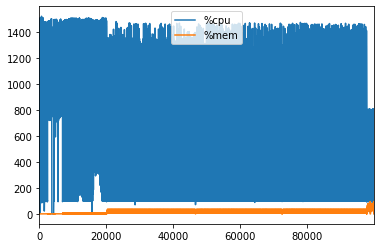

In [3]:
memory.iloc[:100000].plot(y=percentage_cols)

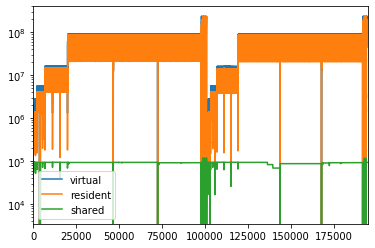

In [4]:
memory.plot(y=memory_cols, logy=True)

In [5]:
memory['l'] = np.nan
memory.l[0:225] = 50
memory.l[250:525] = 100
memory.l[550:1000] = 200
memory.l[1100:2300] = 500
memory.l[2500:6500] = 1000
memory.l[7000:20000] = 2000
memory.l[20000:90000] = 5000

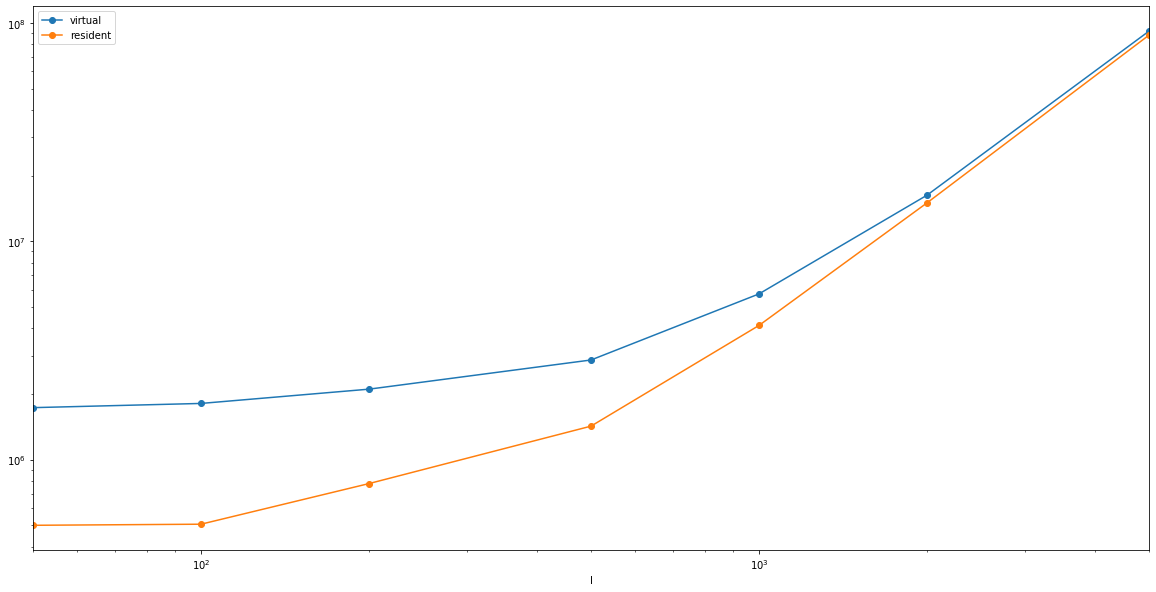

In [6]:
memory.groupby('l').max().plot(marker='o', y=['virtual', 'resident'], figsize=(20, 10), logy=True, logx=True)

TODO:
- l -> #nodes, with ticks, just resident memory

In [7]:
time = pd.read_csv('../../data/behaviour/memory-time/git=0335ce8eed-l=50,100,200,500,1000,2000,5000,10000-k=10-diml1enc=100-diml1dec=100-dimxiadj=16-dimxifeat=16-overlap=0,8,16-bias=false-sharedl1=false-decadjdeep=true,false-nepochs=200.csv')

time_pattern = re.compile('Time: ([0-9]+:[0-9]+:[0-9]+)')
def parse_time(s):
    match = re.search(time_pattern, s)
    if match is None:
        assert "OutOfMemory" in s
        return np.nan
    parts = match.groups()[0].split(':')
    return int(parts[-1]) + 60 * int(parts[-2]) + 3600 * int(parts[-3])

time['ComputeTime'] = time.Stderr.map(parse_time)
time = time[['Seq', 'JobRuntime', 'decadjdeep', 'l', 'k', 'dimxi', 'ComputeTime']]

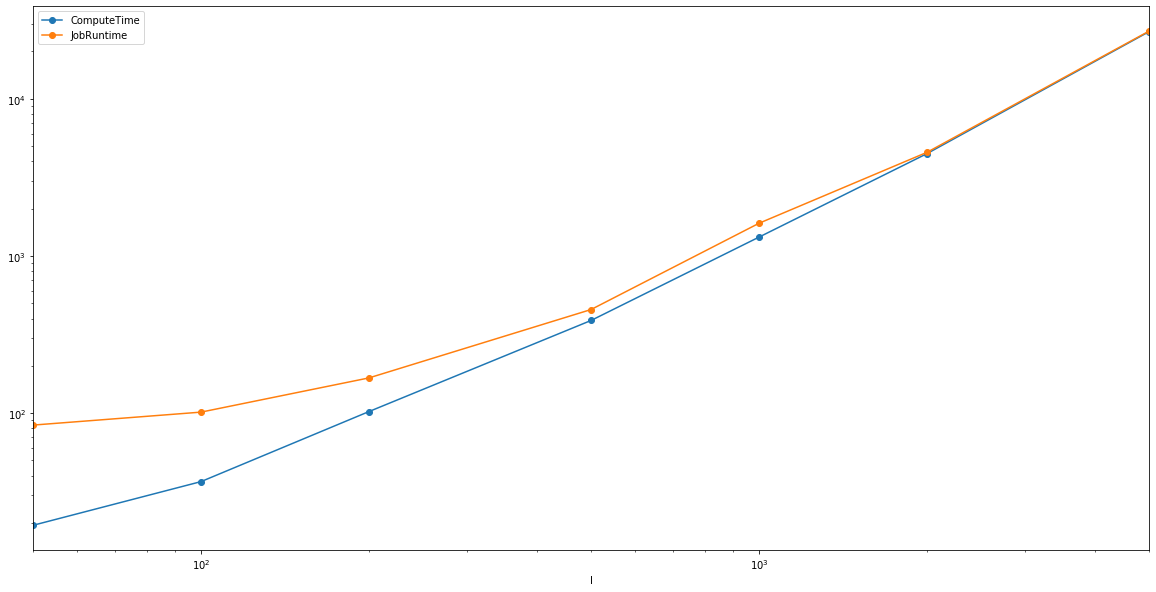

In [8]:
time[time.decadjdeep == True].groupby('l')['ComputeTime', 'JobRuntime'].mean().dropna().plot(marker='o', figsize=(20, 10), logx=True, logy=True)

TODO:
- Mention that if the number of threads is fixed, this trend will be the same, but the absolute values will change if you use more threads.